In [1]:
# imports
import numpy as np
import cdflib
import matplotlib.pyplot as plt
import resampy 
import pyrubberband as pyrb
import scipy.signal as signal
import scipy.io.wavfile as wav
import IPython.display as ipd
from engineering_notation import EngNumber

# Sonification Notebook - Celestial Bodies

In [2]:
# load data and display infomation
file_str_whistle = 'SW_OPER_WHIAEVT_2__20190513T123901_20190513T235959_0201'
file_str_wind = 'CH_OPER_WND_ACC_2__20000729T000000_20000729T235959_0001'
data_crosswind = cdflib.CDF('ESA-Swarm-Handbook/' + file_str_wind + '.cdf')
data_whistle = cdflib.CDF('ESA-Swarm-Handbook/' + file_str_whistle + '.cdf')
#data_whistle.cdf_info()

Sampling Rate Crosswind: 100mHz


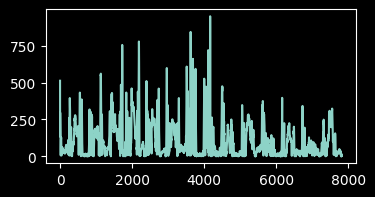

Plaback rate: 10kHz


In [3]:
cw = data_crosswind.varget('crosswind')
cw = cw[cw <= 1e3]
time_data = data_crosswind.varget('time')/1000 # convert from milliseconds to seconds
fs_crosswind = 1/(time_data[1] - time_data[0])
print(f'Sampling Rate Crosswind: {EngNumber(fs_crosswind)}Hz')

with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=[4,2],dpi=100)
    ax.plot(cw)
    plt.show()

rate = int(fs_crosswind*10e4)
print(f'Plaback rate: {EngNumber(rate)}Hz')
ipd.Audio(cw, rate=rate)

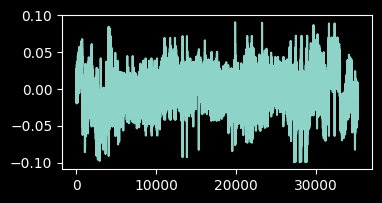

In [4]:
######################################
### WHISTLER DATA PRE-CONDITIONING ###
######################################

whistle = data_whistle.varget('F_analysed')
whistle = np.ravel(whistle)
whistle = whistle[np.abs(whistle) < 0.1]
fs_whistle = 250

with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=[4,2],dpi=100)
    ax.plot(whistle)
    plt.show()

ipd.Audio(whistle, rate=fs_whistle)

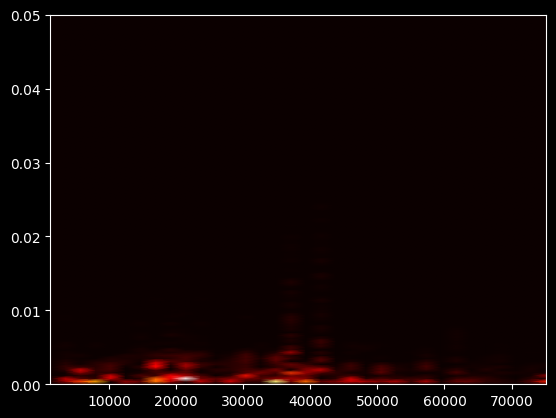

In [5]:
with plt.style.context('dark_background'):
    f, t, Sxx = signal.spectrogram(cw, fs=fs_crosswind)
    plt.pcolormesh(t, f, Sxx[:], shading='gouraud', cmap='hot')
    plt.show()

In [6]:
## -- FUNCTIONS -- ##

def normalizeSignal(magnitude) -> np.ndarray:
    '''Convert magnitude data into normalized +1/-1 floating point range'''
    magnitude[np.isnan(magnitude)] = 0
    magMax = magnitude.max()
    magMin = magnitude.min()

    # remove DC/average
    magDC = np.nanmean(magnitude)
    magOffsetRemoved = magnitude - magDC

    # calculate peak-to-peak and normalize
    ptp = (magMax-magMin)
    magScaled = magOffsetRemoved / ptp
    return magScaled


def highpassFilter(x, fs=1, N=8, fc=0.0001):
    '''Create a Butterworth highpass filter to remove the DC offset'''
    sos = signal.butter(N, fc, 'highpass', fs=fs, output='sos')
    return signal.sosfilt(sos, x)


def resampling(x, pitch_factor=7, fs_old=1, fs_new=44100):
    '''Resampling of the original signal. The pitch factor introduces a pitch shift
    when playing the resampled signal at `fs_new`.'''
    y = resampy.resample(x, fs_old, int(fs_new/(pitch_factor)))
    return y


def smoothingWindow(x, fs=44100, t_fade=0.1):
    ''' Create smoothing window to avoid clicks and pops in the start and end of the signal'''
    window = np.ones(len(x))
    L = int(t_fade * fs)
    fade = np.linspace(0,1,L)    

    for i in range(L):
        window[i] *= fade[i]
        window[len(window)-1-i] *= fade[i]

    y = x * window
    return y


def timeStretching(x, T_length_TS, fs=44100):
    '''Time stretching. T_length_TS is in seconds'''
    T_length = len(x) / fs
    TS_ratio = T_length / T_length_TS
    y = pyrb.time_stretch(x, fs, TS_ratio)
    return y


def pitchShifting(x, semitones=0, fs=44100):
    '''Pitch shifting'''
    return pyrb.pitch_shift(x, fs, semitones)


def saveWav(x, filename, fs=44100):
    save = True
    if save:
        wav_format = np.int16
        wav_amp_scaling = np.iinfo(wav_format).max
        data = wav_amp_scaling*x
        wav.write(filename, fs, data.astype(wav_format))
        print(f'Wav-file saved as \"{filename}\" {fs}Hz {np.iinfo(wav_format).bits} bits\n')
    else:
        print(f'Wav-file not saved\n')


def sonifyDSPchain(x, 
                   fs_old=2500, 
                   fs_new=44100, 
                   pitch_factor=10, 
                   TS=True,
                   length_seconds=10, 
                   PS=True,
                   pitch=0):
    '''
    - Normalize magnitude data
    - Create highpass filter
    - Resampling with a pitch factor.
    - Apply smoothing window
    - Apply time stretching 
    - Apply pitch shifting'''
    
    x = normalizeSignal(x)
    x = highpassFilter(x, fs=fs_old)
    x = resampling(x, fs_old=fs_old, fs_new=fs_new, pitch_factor=pitch_factor)
    x = smoothingWindow(x, fs=fs_out, t_fade=0.05)
    
    if TS:
        x = timeStretching(x, T_length_TS=length_seconds, fs=fs_new)

    if PS:
        x = pitchShifting(x, semitones=pitch, fs=fs_new)
    return x

## --------------- ##


In [17]:
# SONIFYYYY - Whistles

savefile=True

###############
### OPTIONS ###
###############

fs_out = 44100 # output sampling frequency
pitchfactor_resamp = 5

# Pitch shifting enabled?
PS = True
semitones = 0

# Time stretch enabled?
TS = True
length_seconds = 60 

######################
## RUN SONIFICATION ##
######################

x = sonifyDSPchain(whistle, 
                   fs_old=fs_whistle, 
                   fs_new=fs_out, 
                   pitch_factor=pitchfactor_resamp, 
                   TS=TS, 
                   length_seconds=length_seconds, 
                   PS=PS, 
                   pitch=semitones)

#################
# SAVE WAVEFILE #
#################

save_str = 'data=' + file_str_whistle + '_pitchfactor=' + f'{pitchfactor_resamp:.0f}'

if PS:
    save_str = save_str + '_PS=' + f'{semitones:.0f}'

if TS:
    save_str = save_str + '_TS=' + f'{length_seconds:.0f}' + 's'

if savefile:
    saveWav(x, '../wav-files/' + save_str + '.wav')

Wav-file saved as "../wav-files/data=SW_OPER_WHIAEVT_2__20190513T123901_20190513T235959_0201_pitchfactor=5_PS=0_TS=60s.wav" 44100Hz 16 bits

